In [2]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [3]:
dff = pd.read_csv('/Users/kayadetunji/Documents/AWI_GEN_PROJECT/cvd_data_awigenv1.csv').drop(columns = 
       ['Unnamed: 0', 'study_id', 'chf_meds_qc','angina_meds_qc', 'pain_action_stop_or_slow_qc', 'pain_action_rest_qc',
       'pain_action_medicine_qc', 'pain_action_carry_on_qc', 'chf_treat_now_qc', 'chf_treatment_yn_qc',
       'relief_standstill_qc', 'relief_standstill_qc.1', 'pain_location_1_qc',
       'pain_location_2_qc', 'pain_location_3_qc', 'pain_location_4_qc',
       'pain_location_5_qc', 'pain_location_6_qc', 'pain_location_7_qc',
       'pain_location_8_qc', 'pain_location_9_qc', 'pain_location_10_qc',
       'pain_location_11_qc', 'pain_location_12_qc', 'pain_location_13_qc',
       'pain_location_14_qc', 'pain_location_15_qc', 'pain_location_16_qc',
       'pain_location_17_qc', 'pain_location_18_qc','angina_treat_now_qc', 'angina_traditional_qc', 'pain_qc', 'pain2_qc'])

In [4]:
# dff = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv')

#### Slice out urban sites: Nairobi and Soweto

In [23]:
site_id = 3 # Nairobi
Nairobi_dff = dff[(dff['site'] == site_id) & (dff['age'] <= 60) & (dff['age'] >= 40)].copy()

site_id = 6 # Soweto
Soweto_dff = dff[(dff['site'] == site_id) & (dff['age'] <= 60) & (dff['age'] >= 40)].copy()

### Slice out rural sites

In [24]:
site_id = 1 # Agincourt
Agincourt_dff = dff[(dff['site'] == site_id) & (dff['age'] <= 60) & (dff['age'] >= 40)].copy()

site_id = 2 # Dimamo
Dimamo_dff = dff[(dff['site'] == site_id) & (dff['age'] <= 60) & (dff['age'] >= 40)].copy()

In [7]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [8]:
com=[]
for i in range(dff.shape[0]):
    com.append(calculate_CVD(dff.stroke_qc.iloc[i], dff.transient_ischemic_attack_qc.iloc[i], dff.heartattack_qc.iloc[i], dff.congestive_heart_failure_qc.iloc[i], dff.angina_qc.iloc[i]))
y1=pd.DataFrame(com, columns=['CVD'])

In [9]:
y1.value_counts(normalize=True)*100

CVD
0      96.318152
1       3.681848
dtype: float64

In [10]:
y1.CVD

0        0
1        0
2        0
3        0
4        0
        ..
12027    0
12028    0
12029    0
12030    0
12031    0
Name: CVD, Length: 12032, dtype: int64

In [11]:
Soweto_dff.hiv_final_status_c.value_counts(normalize=True)*100

0    58.460779
2    25.801677
1    15.737543
Name: hiv_final_status_c, dtype: float64

In [12]:
dff.loc[dff['site']==6]

,site,age,sex,number_of_children_c,partnership_status_c_qc,highest_level_of_education_qc,occupation_qc,ses_site_quintile_c_qc,smoking_status_c_qc,alcohol_use_status_c_qc,...,heartattack_qc.1,heartattack_treatment_qc,heartattack_traditional_qc,congestive_heart_failure_qc,chf_traditional_qc,cadiovascular_current,ckd_c_qc,htn_jnc7_qc,diabetes_status_c_qc,bmi_c_qc
352,6,40,0,NaN,2,2,1,3,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,22.26
369,6,43,0,NaN,-999,-999,1,-999,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,29.85
377,6,41,0,NaN,-999,1,1,2,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,20.98
379,6,59,0,NaN,-999,-999,4,-999,1,-999,...,-999,-999,-999,-999,-999,NaN,-999,1,0,26.32
397,6,53,0,NaN,2,1,4,3,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,41.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11981,6,48,0,NaN,-999,-999,1,-999,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,1,35.41
11985,6,57,0,NaN,-999,-999,4,-999,2,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,56.46
12000,6,41,0,NaN,1,2,1,1,0,-999,...,-999,-999,-999,-999,-999,NaN,-999,0,0,27.10
12025,6,44,1,5.0,1,2,0,5,2,1,...,-999,-999,-999,-999,-999,0.0,0,0,0,39.20


In [13]:
print('CVD prevalence in Nairobi:\t', Nairobi_dff.cadiovascular_current.value_counts(normalize=True)[1]*100)
print('CVD prevalence in Soweto: \t', Soweto_dff.cadiovascular_current.value_counts(normalize=True)[1]*100)

CVD prevalence in Nairobi:	 4.6416382252559725
CVD prevalence in Soweto: 	 3.51219512195122


In [14]:
print('CKD prevalence in Nairobi:\t', Nairobi_dff.ckd_c_qc.value_counts(normalize=True)[1]*100)
print('CKD prevalence in Soweto: \t', Soweto_dff.ckd_c_qc.value_counts(normalize=True)[1]*100)

CKD prevalence in Nairobi:	 15.085324232081913
CKD prevalence in Soweto: 	 6.364084854464726


In [15]:
print('HT prevalence in Nairobi:\t', Nairobi_dff.htn_jnc7_qc.value_counts(normalize=True)[1]*100)
print('HT prevalence in Soweto: \t', Soweto_dff.htn_jnc7_qc.value_counts(normalize=True)[1]*100)

HT prevalence in Nairobi:	 51.94539249146758
HT prevalence in Soweto: 	 53.23137641835225


In [16]:
print('DM prevalence in Nairobi:\t', Nairobi_dff.diabetes_status_c_qc.value_counts(normalize=True)[1]*100)
print('DM prevalence in Soweto: \t', Soweto_dff.diabetes_status_c_qc.value_counts(normalize=True)[1]*100)

DM prevalence in Nairobi:	 6.484641638225256
DM prevalence in Soweto: 	 9.422792303897385


In [17]:
print('HIV prevalence in Nairobi:\t', Nairobi_dff.hiv_final_status_c.value_counts(normalize=True)[1]*100)
print('HIV prevalence in Soweto: \t', Soweto_dff.hiv_final_status_c.value_counts(normalize=True)[1]*100)

HIV prevalence in Nairobi:	 34.470989761092156
HIV prevalence in Soweto: 	 15.73754316724223


In [18]:
CVD_CKD = ['cadiovascular_current', 'ckd_c_qc']
CVD_HT = ['cadiovascular_current', 'htn_jnc7_qc']
CVD_DM = ['cadiovascular_current', 'diabetes_status_c_qc']
target_col = 'CVD_CKD'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[CVD_CKD] == 1).sum(axis = 1) == 2

In [19]:
target_col = 'CVD_HT'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[CVD_HT] == 1).sum(axis = 1) == 2

In [20]:
target_col = 'CVD_DM'

# defining the target column to be a column where the sum of the target values >= 2
dff[target_col] = (dff[CVD_DM] == 1).sum(axis = 1) == 2

In [21]:
dff.loc[:,['CVD_CKD','CVD_HT','CVD_DM', 'htn_jnc7_qc', 'diabetes_status_c_qc','cadiovascular_current']].head(20)

,CVD_CKD,CVD_HT,CVD_DM,htn_jnc7_qc,diabetes_status_c_qc,cadiovascular_current
0,False,False,False,1,0,NaN
1,False,False,False,1,0,NaN
2,False,False,False,0,0,NaN
3,False,False,False,1,0,NaN
4,False,False,False,1,0,NaN
5,False,False,False,0,0,NaN
6,False,False,False,0,0,NaN
7,False,False,False,1,0,NaN
8,False,False,False,1,1,NaN
9,False,False,False,1,0,NaN


In [25]:
print('CVD + HT prevalence in Nairobi:\t', Nairobi_dff.CVD_HT.value_counts(normalize=True)[1]*100)
print('CVD + HT prevalence in Soweto: \t', Soweto_dff.CVD_HT.value_counts(normalize=True)[1]*100)

CVD + HT prevalence in Nairobi:	 1.2873326467559219
CVD + HT prevalence in Soweto: 	 0.986679822397632


In [26]:
print('CVD + DM prevalence in Nairobi:\t', Nairobi_dff.CVD_DM.value_counts(normalize=True)[1]*100)
print('CVD + DM prevalence in Soweto: \t', Soweto_dff.CVD_DM.value_counts(normalize=True)[1]*100)

CVD + DM prevalence in Nairobi:	 0.5149330587023687
CVD + DM prevalence in Soweto: 	 0.049333991119881605


In [27]:
print('CVD + CKD prevalence in Nairobi:\t', Nairobi_dff.CVD_CKD.value_counts(normalize=True)[1]*100)
print('CVD + CKD prevalence in Soweto: \t', Soweto_dff.CVD_CKD.value_counts(normalize=True)[1]*100)

CVD + CKD prevalence in Nairobi:	 0.7209062821833162
CVD + CKD prevalence in Soweto: 	 0.19733596447952642


In [35]:
dff.loc[:,['htn_jnc7_qc', 'diabetes_status_c_qc','cadiovascular_current']].loc[((dff['site'] == 3) | (dff['site'] == 6)) ]

,htn_jnc7_qc,diabetes_status_c_qc,cadiovascular_current
182,0,0,0.0
352,0,0,NaN
369,0,0,NaN
370,1,0,0.0
377,0,0,NaN
...,...,...,...
12014,0,0,NaN
12017,0,0,0.0
12025,0,0,0.0
12026,1,0,0.0


In [33]:
dff.loc[:,['htn_jnc7_qc', 'diabetes_status_c_qc','cadiovascular_current']]

,htn_jnc7_qc,diabetes_status_c_qc,cadiovascular_current
0,1,0,NaN
1,1,0,NaN
2,0,0,NaN
3,1,0,NaN
4,1,0,NaN
...,...,...,...
12027,1,1,NaN
12028,1,0,0.0
12029,0,0,NaN
12030,0,0,0.0


In [42]:
conditions_upset = dff.loc[:,['htn_jnc7_qc', 'diabetes_status_c_qc','ckd_c_qc','cadiovascular_current']].loc[((dff['site'] == 3) | (dff['site'] == 6)) ].mask(dff == 1, np.nan)
pd.isna(conditions_upset)

,htn_jnc7_qc,diabetes_status_c_qc,ckd_c_qc,cadiovascular_current
182,False,False,False,False
352,False,False,False,True
369,False,False,False,True
370,True,False,True,False
377,False,False,False,True
...,...,...,...,...
12014,False,False,False,True
12017,False,False,False,False
12025,False,False,False,False
12026,True,False,False,False


In [43]:
site = dff.loc[((dff['site'] == 3) | (dff['site'] == 6)) ].reindex(columns=['site']).copy()
conditions_upset1 = pd.concat([conditions_upset, site], axis=1)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'extra0': <Axes: ylabel='Count by site'>}

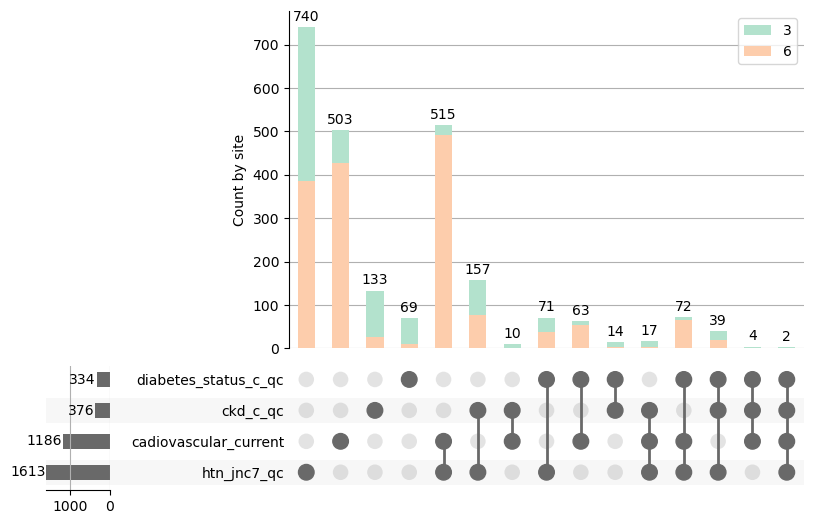

In [44]:
import upsetplot
from upsetplot import UpSet, plot, from_indicators
from upsetplot import from_contents
from matplotlib import cm
upset = UpSet(from_indicators(pd.isna, data=conditions_upset1), show_counts=True, max_subset_size=1000,intersection_plot_elements=0, facecolor='dimgrey')
upset.add_stacked_bars(by="site", colors=cm.Pastel2,
                       title="Count by site", elements=10)
upset.plot()

In [ ]:
upset = UpSet(from_indicators(pd.isna, data=conditions_upset), show_counts=True, max_subset_size=100, facecolor='dimgrey')
upset.style_subsets(present=["stroke_qc", "transient_ischemic_attack_qc"],
                    absent=['angina_qc', 'congestive_heart_failure_qc', 'heartattack_qc'],
                    facecolor="orange",
                    label="stroke/TIA cases")
upset.style_subsets(present=["stroke_qc", "transient_ischemic_attack_qc", 'angina_qc'],
                    absent=['heartattack_qc'],
                    facecolor="red",
                    label="CHF/stroke/TIA cases")
upset.plot()